In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data = pd.read_csv('PS_20174392719_1491204439457_log.csv', nrows=50000)

In [3]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
49995,9,PAYMENT,1322.91,C1402545110,1208457.61,1207134.71,M578074960,0.0,0.0,0,0
49996,9,PAYMENT,6900.48,C517372485,1207134.71,1200234.22,M1854114037,0.0,0.0,0,0
49997,9,PAYMENT,17399.12,C1948160352,1200234.22,1182835.10,M1940330634,0.0,0.0,0,0
49998,9,PAYMENT,5485.20,C1586381033,1182835.10,1177349.90,M741912557,0.0,0.0,0,0


In [4]:
data['isFraud'].value_counts()

0    49900
1      100
Name: isFraud, dtype: int64

In [5]:
{column: len(data[column].unique()) for column in data.columns}

{'step': 9,
 'type': 5,
 'amount': 49786,
 'nameOrig': 50000,
 'oldbalanceOrg': 30572,
 'newbalanceOrig': 24328,
 'nameDest': 28499,
 'oldbalanceDest': 25369,
 'newbalanceDest': 9367,
 'isFraud': 2,
 'isFlaggedFraud': 1}

In [6]:
data['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [7]:
pd.get_dummies(data['type'], prefix='tp')

,tp_CASH_IN,tp_CASH_OUT,tp_DEBIT,tp_PAYMENT,tp_TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0
...,...,...,...,...,...
49995,0,0,0,1,0
49996,0,0,0,1,0
49997,0,0,0,1,0
49998,0,0,0,1,0


In [8]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [9]:
def preprocess_inputs(df):
    df = df.copy()
    
    
    # Drop step, nameOrig, and isFlaggedFraud columns
    df = df.drop(['step', 'nameOrig', 'isFlaggedFraud'], axis=1)
    
    
    # One-hot encode the type column
    df = onehot_encode(df, column='type', prefix='tp')
    
    y = df['isFraud'].copy()
    X = df.drop('isFraud', axis=1).copy()
    
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    
    # Create a tokenizer and fit it to the customer data
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(X_train['nameDest'])
    
    print("Total # of customers:", len(tokenizer.word_index))
    
    
    # Create tokenized customer lists
    customers_train = tokenizer.texts_to_sequences(X_train['nameDest'])
    customers_test = tokenizer.texts_to_sequences(X_test['nameDest'])
    
    
    # Pad sequences
    customers_train = tf.keras.preprocessing.sequence.pad_sequences(customers_train, maxlen=1)
    customers_test = tf.keras.preprocessing.sequence.pad_sequences(customers_test, maxlen=1)
    
    
    # Drop nameDest column
    X_train = X_train.drop('nameDest', axis=1)
    X_test = X_test.drop('nameDest', axis=1)
    
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    
    return X_train, X_test, customers_train, customers_test, y_train, y_test

In [10]:
X_train, X_test, customers_train, customers_test, y_train, y_test = preprocess_inputs(data)

Total # of customers: 21017


In [11]:
customers_train

array([[ 3450],
       [ 3451],
       [  579],
       ...,
       [ 1149],
       [  685],
       [21017]])

In [12]:
train_df = pd.concat([X_train, pd.Series(np.squeeze(customers_train), name='customer'), y_train.reset_index(drop=True)], axis=1)

In [13]:
train_df['isFraud'].value_counts()

0    34929
1       71
Name: isFraud, dtype: int64

In [14]:
oversampled_data = train_df.query("isFraud == 1").sample(34858, replace=True, random_state=123)

In [15]:
train_df = pd.concat([train_df, oversampled_data], axis=0).sample(frac=1.0, random_state=123).reset_index(drop=True)

In [16]:
train_df

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,tp_CASH_IN,tp_CASH_OUT,tp_DEBIT,tp_PAYMENT,tp_TRANSFER,customer,isFraud
0,-0.455241,-0.328050,-0.333403,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,-0.880868,3.082377,13802,1
1,-0.433171,1.673388,1.646507,-0.299754,-0.366017,2.147900,-0.618309,-0.115403,-0.880868,-0.324425,1030,0
2,-0.474980,-0.309417,-0.312245,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425,3572,0
3,-0.388713,-0.332726,-0.333403,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425,5835,0
4,-0.469634,-0.332726,-0.333403,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425,4713,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69853,-0.444370,-0.326458,-0.333403,-0.345862,-0.350505,-0.465571,1.617313,-0.115403,-0.880868,-0.324425,2342,1
69854,-0.455568,-0.328098,-0.333403,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,-0.880868,3.082377,8999,1
69855,-0.453397,-0.332726,-0.333403,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425,12402,0
69856,-0.442919,-0.088634,-0.099816,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425,17568,0


In [17]:
train_df['isFraud'].value_counts()

0    34929
1    34929
Name: isFraud, dtype: int64

In [18]:
customers_train = train_df['customer'].copy()
y_train = train_df['isFraud'].copy()
X_train = train_df.drop(['customer', 'isFraud'], axis=1).copy()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_input (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
customer_input (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
X_dense1 (Dense)                (None, 64)           704         X_input[0][0]                    
__________________________________________________________________________________________________
customer_embedding (Embedding)  (None, 1, 64)        1345152     customer_input[0][0]             
_______________________________________________________________________________________

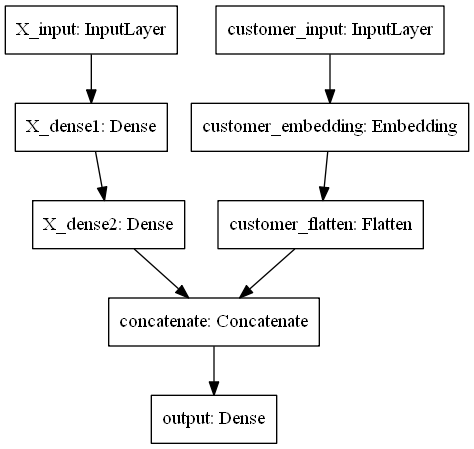

In [19]:
X_inputs = tf.keras.Input(shape=(10,), name='X_input')
customer_inputs = tf.keras.Input(shape=(1,), name='customer_input')

# X
X_dense1 = tf.keras.layers.Dense(64, activation='relu', name='X_dense1')(X_inputs)
X_dense2 = tf.keras.layers.Dense(64, activation='relu', name='X_dense2')(X_dense1)

# customers
customer_embedding = tf.keras.layers.Embedding(
    input_dim=21018,
    output_dim=64,
    input_length=1,
    name='customer_embedding'
)(customer_inputs)
customer_flatten = tf.keras.layers.Flatten(name='customer_flatten')(customer_embedding)

# Concatenate
concat = tf.keras.layers.concatenate([X_dense2, customer_flatten], name='concatenate')

# Output
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(concat)


model = tf.keras.Model(inputs=[X_inputs, customer_inputs], outputs=outputs)

print(model.summary())
tf.keras.utils.plot_model(model)

In [20]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

Training

In [21]:
history = model.fit(
    [X_train, customers_train],
    y_train,
    validation_split=0.2,
    class_weight={
        0: 0.25,
        1: 4.0
    },
    batch_size=32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
1747/1747 [==============================] - 20s 11ms/step - loss: 0.0703 - accuracy: 0.9319 - auc: 0.9951 - val_loss: 0.0118 - val_accuracy: 0.9979 - val_auc: 0.9991
Epoch 2/10
1747/1747 [==============================] - 15s 9ms/step - loss: 0.0037 - accuracy: 0.9982 - auc: 0.9988 - val_loss: 0.0094 - val_accuracy: 0.9984 - val_auc: 0.9994
Epoch 3/10
1747/1747 [==============================] - 16s 9ms/step - loss: 0.0031 - accuracy: 0.9984 - auc: 0.9990 - val_loss: 0.0091 - val_accuracy: 0.9986 - val_auc: 0.9994
Epoch 4/10
1747/1747 [==============================] - 16s 9ms/step - loss: 0.0031 - accuracy: 0.9985 - auc: 0.9991 - val_loss: 0.0084 - val_accuracy: 0.9986 - val_auc: 0.9994
Epoch 5/10
1747/1747 [==============================] - 15s 9ms/step - loss: 0.0025 - accuracy: 0.9986 - auc: 0.9992 - val_loss: 0.0057 - val_accuracy: 0.9988 - val_auc: 0.9996
Epoch 6/10
1747/1747 [==============================] - 16s 9ms/step - loss: 0.0023 - accuracy: 0.9988 - auc: 0.99

# Results

In [22]:
results = model.evaluate([X_test, customers_test], y_test, verbose=0)
print("Test Accuracy: {:.3f}%".format(results[1] * 100))
acctf =results[1] * 100
print(acctf)
print("     Test AUC: {:.3f}".format(results[2] * 100))

Test Accuracy: 99.720%
99.72000122070312
     Test AUC: 77.267


In [23]:
%store acctf

Stored 'acctf' (float)


In [24]:
y_true = np.array(y_test)

y_pred = np.squeeze(model.predict([X_test, customers_test]))
y_pred = (y_pred >= 0.5).astype(np.int)


cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=["Not Fraud", "Fraud"])

<ipython-input-24-5d190804a4e5>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = (y_pred >= 0.5).astype(np.int)


In [28]:
tf01 = cm[0,1]
tf10 = cm[1,0]

In [30]:
%store tf01
%store tf10

Stored 'tf01' (int64)
Stored 'tf10' (int64)


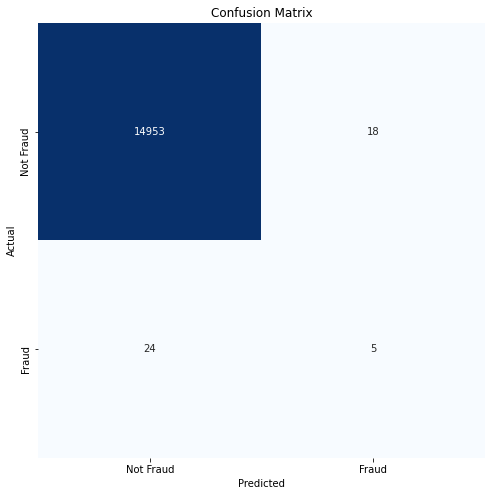

In [25]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(2) + 0.5, ["Not Fraud", "Fraud"])
plt.yticks(np.arange(2) + 0.5, ["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [26]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     14971
       Fraud       0.22      0.17      0.19        29

    accuracy                           1.00     15000
   macro avg       0.61      0.59      0.60     15000
weighted avg       1.00      1.00      1.00     15000

